In [2]:
%load_ext autoreload
%autoreload 2

In [97]:
import pandas as pd
import json
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from scipy.stats import linregress
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import plotly_express as px
import numpy as np
import seaborn as sns
from glob import glob
from memory_profiler import profile

In [4]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def find_kl_div_blowup(steps: List[Dict], threshold: float = 0.5) -> Tuple[int, float]:
    for step in steps:
        if step["kl_div"] >= threshold:
            return step["step"]
    # Return the last step and its normalized KL div if threshold is never reached
    return len(steps)


def classify_perturbation_type(steps: List[Dict]) -> str:
    kl_divs = [step["kl_div"] for step in steps]

    # Check for initial plateau
    initial_slope = linregress(range(10), kl_divs[:10]).slope

    # Check for rapid increase
    max_slope = max(kl_divs[i + 1] - kl_divs[i] for i in range(len(kl_divs) - 1))

    if initial_slope < 0.01 and max_slope > 0.1:
        return "plateau_then_rapid"
    elif all(kl_divs[i] <= kl_divs[i + 1] for i in range(len(kl_divs) - 1)):
        return "monotonic_increase"
    else:
        return "other"


def compute_prompt_embedding(prompt: List[int], model) -> np.ndarray:
    with torch.no_grad():
        # Convert token IDs to tensor
        tokens_tensor = torch.tensor(prompt).unsqueeze(0)  # Add batch dimension
        # Get embeddings
        embeddings = model.embed(tokens_tensor)
        # Average embeddings across token dimension
        mean_embedding = embeddings.mean(dim=1)
    return mean_embedding


def compute_prompt_cosine_sim(start_prompt, end_prompt, model):
    start_emb = compute_prompt_embedding(start_prompt, model)
    end_emb = compute_prompt_embedding(end_prompt, model)
    return torch.cosine_similarity(start_emb, end_emb).item()

## Finding KL div threshold

In [5]:
raw_observations = []

for filepath in glob("observations/*"):
    obs_data = load_jsonl(filepath)
    raw_observations.extend(obs_data)

In [6]:
len(raw_observations)

10500

In [7]:
# Run this analysis on your observations
# analyze_kl_div_distribution(raw_observations)

## Processing observations data

In [9]:
from transformer_lens import HookedTransformer
from collections import Counter, defaultdict

In [10]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [11]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

sae.eval()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [105]:
def get_active_features_properties_sorted(step):
    feature_acts_total = sum(step["active_feature_acts"])
    active_feature_acts_norm = [
        round(a / feature_acts_total, 2) for a in step["active_feature_acts"]
    ]
    active_features_act_spars = sorted(
        zip(
            step["active_feature_ids"],
            step["active_feature_acts"],
            active_feature_acts_norm,
            step["active_feature_sparsities"],
        ),
        key=lambda x: x[1],
        reverse=True,
    )
    return active_features_act_spars


def get_top_features_act(step, step_id):
    active_features_act_spars = get_active_features_properties_sorted(step)
    (
        (feat1, act1, act_norm1, spars1),
        (feat2, act2, act_norm2, spars2),
        (feat3, act3, act_norm3, spars3),
    ) = active_features_act_spars[:3]

    # feat1_dir = get_feature_dir(sae, feat1)
    # feat2_dir = get_feature_dir(sae, feat2)
    # feat3_dir = get_feature_dir(sae, feat3)

    # feat1_feat2_cos_sim = torch.cosine_similarity(feat1_dir.unsqueeze(0), feat2_dir.unsqueeze(0)).item()
    # feat1_feat3_cos_sim = torch.cosine_similarity(feat1_dir.unsqueeze(0), feat3_dir.unsqueeze(0)).item()
    # feat2_feat3_cos_sim = torch.cosine_similarity(feat2_dir.unsqueeze(0), feat3_dir.unsqueeze(0)).item()

    # feat1_l0_inverse_recon = calculate_l0(sae.encode(feat1_dir))
    # feat2_l0_inverse_recon = calculate_l0(sae.encode(feat2_dir))
    # feat3_l0_inverse_recon = calculate_l0(sae.encode(feat3_dir))

    return {
        f"{step_id + 1}_act_top_1_sae_feature_id": feat1,
        f"{step_id + 1}_act_top_1_sae_feature_act": act1,
        f"{step_id + 1}_act_top_1_sae_feature_act_norm": act_norm1,
        f"{step_id + 1}_act_top_1_sae_feature_sparsity": spars1,
        f"{step_id + 1}_act_top_2_sae_feature_id": feat2,
        f"{step_id + 1}_act_top_2_sae_feature_act": act2,
        f"{step_id + 1}_act_top_2_sae_feature_act_norm": act_norm2,
        f"{step_id + 1}_act_top_2_sae_feature_sparsity": spars2,
        f"{step_id + 1}_act_top_3_sae_feature_id": feat3,
        f"{step_id + 1}_act_top_3_sae_feature_act": act3,
        f"{step_id + 1}_act_top_3_sae_feature_act_norm": act_norm3,
        f"{step_id + 1}_act_top_3_sae_feature_sparsity": spars3,
        f"{step_id + 1}_act_l2_norm": step["l2_norm"],
        # f"{step_id + 1}_feat1_feat2_cos_sim": round(feat1_feat2_cos_sim, 4),
        # f"{step_id + 1}_feat1_feat3_cos_sim": round(feat1_feat3_cos_sim, 4),
        # f"{step_id + 1}_feat2_feat3_cos_sim": round(feat2_feat3_cos_sim, 4),
        # f"{step_id + 1}_feat1_l0_inv_recon": feat1_l0_inverse_recon,
        # f"{step_id + 1}_feat2_l0_inv_recon": feat2_l0_inverse_recon,
        # f"{step_id + 1}_feat3_l0_inv_recon": feat3_l0_inverse_recon,
    }


def sae_derived_features(steps):
    num_steps = len(steps)
    all_active_features = [
        feature for step in steps for feature in step["active_feature_ids"]
    ]
    feature_counts = Counter(all_active_features)

    sae_features = {
        k: v
        for step_id, step in enumerate(steps)
        for k, v in get_top_features_act(step, step_id).items()
    }

    return {
        "total_unique_active_features": len(feature_counts),
        "avg_feature_activation_count": (
            round((sum(feature_counts.values()) / len(feature_counts)) / num_steps, 4)
            if feature_counts
            else 0
        ),
        "avg_active_features": np.mean([step["num_active_features"] for step in steps]),
        "std_active_features": np.std([step["num_active_features"] for step in steps]),
        "avg_feature_activation": np.mean(
            [np.mean(step["active_feature_acts"]) for step in steps]
        ),
        "std_feature_activation": np.std(
            [np.mean(step["active_feature_acts"]) for step in steps]
        ),
        **sae_features,
    }


def find_plateau_length(steps: List[Dict], threshold: float = 0.01) -> int:
    kl_divs = [step["kl_div"] for step in steps]
    slopes = [kl_divs[i + 1] - kl_divs[i] for i in range(len(kl_divs) - 1)]

    for i, slope in enumerate(slopes):
        if abs(slope) > threshold:
            return i

    return len(steps) - 1


def calculate_l0(vector, threshold=0.05):
    return np.sum(np.abs(vector.detach().numpy()) > threshold)


def get_feature_dir(sae, feature_id_to_activate):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id_to_activate] = 1

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    return perturbed_act

In [106]:
observations_features = []
seq_len = 10

for filepath in glob("observations/*"):
    print(f"Processing {filepath}")
    obs_data = load_jsonl(filepath)
    for i, obs in enumerate(obs_data):
        token_sim = len(set(obs["start_prompt"]) & set(obs["end_prompt"])) / seq_len

        observations_features.append(
            {
                "id": obs["id"],
                "start_prompt": model.tokenizer.decode(obs["start_prompt"]),
                "end_prompt": model.tokenizer.decode(obs["end_prompt"]),
                "prompts_cos_sim": compute_prompt_cosine_sim(
                    obs["start_prompt"], obs["end_prompt"], model
                ),
                "prompts_token_sim": token_sim,
                "kl_div_blowup_step": find_kl_div_blowup(obs["steps"]),
                "plateau_length": find_plateau_length(obs["steps"]),
                "perturbation_type": classify_perturbation_type(obs["steps"]),
                "final_kl_div": obs["steps"][-1]["kl_div"],
                "final_l2_norm": obs["steps"][-1]["l2_norm"],
                "final_cos_sim": obs["steps"][-1]["cos_sim"],
                **sae_derived_features(obs["steps"]),
            }
        )

        if i % 100 == 0:
            print(f"Processing observation {i + 1}/{len(obs_data)}")

df = pd.DataFrame(observations_features)

Processing observations/observations_500_20240805_231503.jsonl
Processing observation 1/500
Processing observation 101/500
Processing observation 201/500
Processing observation 301/500
Processing observation 401/500
Processing observations/observations_500_20240805_155650.jsonl
Processing observation 1/500
Processing observation 101/500
Processing observation 201/500
Processing observation 301/500
Processing observation 401/500
Processing observations/observations_500_20240805_154701.jsonl
Processing observation 1/500
Processing observation 101/500
Processing observation 201/500
Processing observation 301/500
Processing observation 401/500
Processing observations/observations_500_20240805_164418.jsonl
Processing observation 1/500
Processing observation 101/500
Processing observation 201/500
Processing observation 301/500
Processing observation 401/500
Processing observations/observations_500_20240805_234250.jsonl
Processing observation 1/500
Processing observation 101/500
Processing ob

In [107]:
print(df.shape)
df.head()

(14000, 1317)


,id,start_prompt,end_prompt,prompts_cos_sim,prompts_token_sim,kl_div_blowup_step,plateau_length,perturbation_type,final_kl_div,final_l2_norm,...,100_act_top_1_sae_feature_sparsity,100_act_top_2_sae_feature_id,100_act_top_2_sae_feature_act,100_act_top_2_sae_feature_act_norm,100_act_top_2_sae_feature_sparsity,100_act_top_3_sae_feature_id,100_act_top_3_sae_feature_act,100_act_top_3_sae_feature_act_norm,100_act_top_3_sae_feature_sparsity,100_act_l2_norm
0,53dcb9d4-fc81-4964-a105-7d501e672444,a – an idealist raised on Marxist theory and,"strict, all-girls school in India. She",0.768198,0.0,47,40,plateau_then_rapid,5.347825,3.346462,...,0.000225,24201,0.728791,0.12,0.000212,7550,0.683196,0.11,0.128111,3.346462
1,848e5bfb-5c56-4eb5-99e8-e1724d6fd4ce,a – an idealist raised on Marxist theory and,"problem, and that’ll only be on",0.791752,0.2,44,37,plateau_then_rapid,3.911501,2.230950,...,0.003204,19064,0.591622,0.13,0.043999,15603,0.523604,0.11,0.119497,2.230950
2,3b9d414f-c142-464e-ae31-984062500ad7,a – an idealist raised on Marxist theory and,YE) In Europe<|endoftext|>Share On more Share On,0.719934,0.0,42,35,plateau_then_rapid,3.678581,3.024832,...,0.000118,15603,0.592269,0.10,0.119497,7550,0.571618,0.10,0.128111,3.024832
3,9f58621d-a998-4005-a865-7d6a92a3d948,a – an idealist raised on Marxist theory and,than a better economy. “The only thing,0.787339,0.0,40,32,plateau_then_rapid,5.533917,3.648801,...,0.000290,7550,0.699028,0.11,0.128111,7034,0.658424,0.10,0.080314,3.648801
4,3d5b7764-acb6-4fd6-934f-841e4660b182,a – an idealist raised on Marxist theory and,"the Obama-era program that protects some 800,",0.780357,0.0,50,41,plateau_then_rapid,1.655284,2.339332,...,0.015389,8656,1.304164,0.28,0.018396,19064,0.413014,0.09,0.043999,2.339332


In [108]:
df.to_feather("data/dataset.feather")

## Plotting observations data

In [114]:
df.sample(5)

,id,start_prompt,end_prompt,prompts_cos_sim,prompts_token_sim,kl_div_blowup_step,plateau_length,perturbation_type,final_kl_div,final_l2_norm,...,100_act_top_1_sae_feature_sparsity,100_act_top_2_sae_feature_id,100_act_top_2_sae_feature_act,100_act_top_2_sae_feature_act_norm,100_act_top_2_sae_feature_sparsity,100_act_top_3_sae_feature_id,100_act_top_3_sae_feature_act,100_act_top_3_sae_feature_act_norm,100_act_top_3_sae_feature_sparsity,100_act_l2_norm
0,53dcb9d4-fc81-4964-a105-7d501e672444,a – an idealist raised on Marxist theory and,"strict, all-girls school in India. She",0.768198,0.0,47,40,plateau_then_rapid,5.347825,3.346462,...,0.000225,24201,0.728791,0.12,0.000212,7550,0.683196,0.11,0.128111,3.346462
6183,cd723fd5-e590-4b83-84c1-1410bdccf4ec,"according to you, to employ more locals in IT","5 million backers to date, the issue hardly a...",0.818098,0.2,47,33,plateau_then_rapid,1.855664,3.965402,...,0.000141,7550,0.666719,0.11,0.128111,15603,0.602220,0.10,0.119497,3.965402
6977,cf579103-75d7-471f-87a7-9853bee84170,: 303-954-1174 or jb,.[183]\n\nOther places named after Paul,0.767625,0.0,47,35,plateau_then_rapid,5.186381,3.862543,...,0.000260,7550,0.750232,0.12,0.128111,7034,0.654825,0.10,0.080314,3.862543
10519,a3c41839-16a8-4961-9b64-892c19dc9b56,"have to be terrible\n\n""The 2-",slow to grow lack significant entrepreneurial...,0.771775,0.1,55,46,plateau_then_rapid,10.002610,3.377895,...,0.000532,15603,0.607062,0.10,0.119497,7550,0.582681,0.10,0.128111,3.377895
11050,dcad9be5-ae62-4ac0-96af-8522e4452ede,the Japanese have encouraged employees to sta...,�s requirements are becoming onerous. Some argue,0.782674,0.0,60,45,monotonic_increase,1.041083,4.113106,...,0.000109,7550,0.701094,0.11,0.128111,7034,0.671010,0.10,0.080314,4.113106


In [115]:
# plt.hist(df.kl_div_blowup_step)
# plt.show()

In [219]:
# df[df.final_kl_div >= 1].sort_values(by='kl_div_blowup_step', ascending=True).head(10)

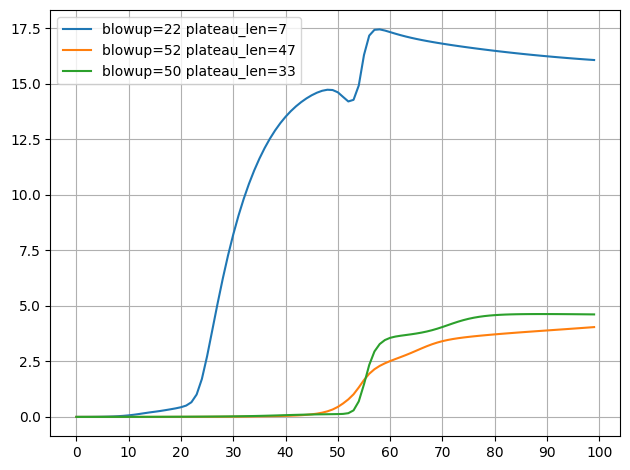

In [113]:
obs_idxs = [958, 4889, 3984]
steps = np.arange(0, 100, 1)

for obs_idx in obs_idxs:
    props = dict(df.loc[obs_idx])
    obs = raw_observations[obs_idx]
    label = (
        f"blowup={props['kl_div_blowup_step']} plateau_len={props['plateau_length']}"
    )
    plt.plot(steps, [s["kl_div"] for s in obs["steps"]], label=label)

plt.xticks(np.arange(0, 101, 10))
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()